###  Libraries

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from Initialization import Initialization
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Rings import Rings
from Common_Modules.Evaluation import Evaluator

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Global Variables

In [2]:
seed = 42
evaluator = Evaluator()
kMeans_is_enabled = False
kernelKMeans_is_enabled = False
kernelKMeansPP_is_enabled = True
globalKernelKMeans_is_enabled = False
globalKernelKMeansPP_is_enabled = True

### Load Dataset

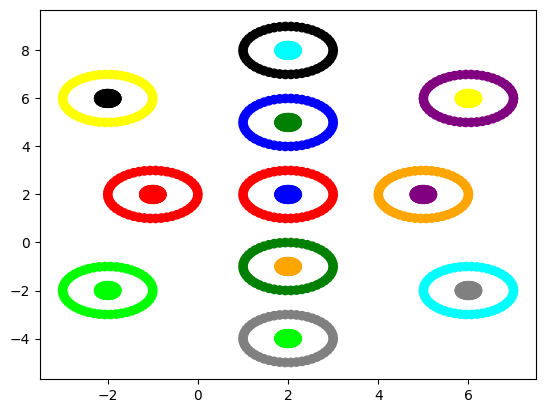

In [3]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

# Generate 5 pairs of data with specified center positions and unique IDs for each ring
centers_coordinates = [(-1, 2), (2, 2), (2, 5), (2, -1), (5, 2), (6, 6), (-2, 6), (2, 8), (6, -2), (2, -4), (-2, -2)]  # Specify center positions for each pair
#centers_coordinates = [(2, 2), (-2, 2)]
rings = Rings()

X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=100, factor=0.2, noise=0.0)
#X, y = rings.remove_samples_with_specific_label(X, y, 3)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors))

In [4]:
K = 22
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)

### kMeans

ACC: 0.68 PUR: 0.70 NMI: 0.86 ARI: 0.62


c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikit_learn-1.3.1-py3.11-win-amd64.egg\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


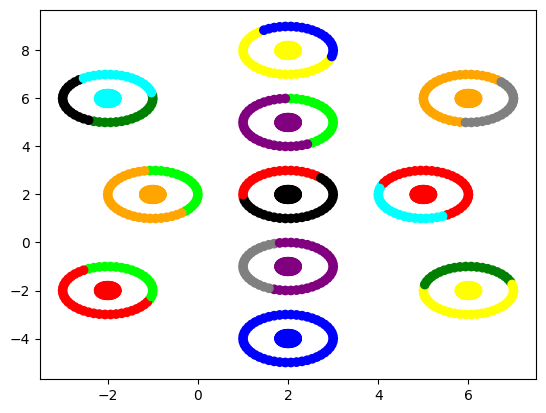

In [5]:
if(kMeans_is_enabled):
    kmeans = KMeans(n_clusters=K).fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=ListedColormap(colors))

### Kernel kMeans

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1100 1-dimensional timeseries
  warnings.warn(


ACC: 0.68 PUR: 0.71 NMI: 0.86 ARI: 0.64


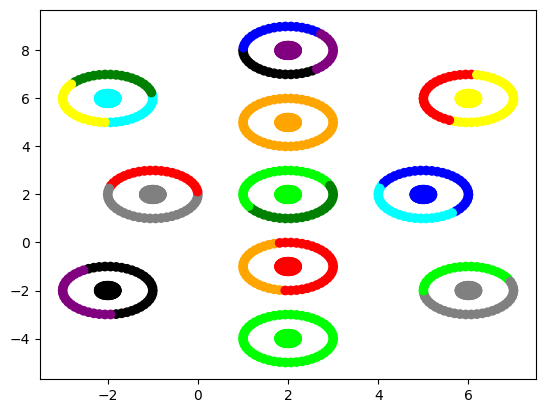

In [6]:
if(kernelKMeans_is_enabled):
    kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_, cmap=ListedColormap(colors))
    plt.show()

### Kernel kMeans++

Execution 0 of Kernel k-Means with k-means++ initialization
Iter: 0 Cl L: 461.8104
Iter: 1 Cl L: 457.8138
Iter: 2 Cl L: 456.1587
Iter: 3 Cl L: 455.0463
Iter: 4 Cl L: 454.2406
Iter: 5 Cl L: 453.0671
Iter: 6 Cl L: 452.7627
Iter: 7 Cl L: 452.5013
Iter: 8 Cl L: 452.1880
Iter: 9 Cl L: 451.6842
Finished in Iter: 10 Cl L: 451.0721
Execution 1 of Kernel k-Means with k-means++ initialization
Iter: 0 Cl L: 508.4678
Iter: 1 Cl L: 501.5372
Iter: 2 Cl L: 497.1404
Iter: 3 Cl L: 494.1838
Iter: 4 Cl L: 492.6180
Iter: 5 Cl L: 491.6040
Iter: 6 Cl L: 489.6029
Iter: 7 Cl L: 474.6522
Iter: 8 Cl L: 450.2628
Iter: 9 Cl L: 449.0053
Iter: 10 Cl L: 448.4362
Iter: 11 Cl L: 447.9086
Iter: 12 Cl L: 447.3859
Iter: 13 Cl L: 446.9490
Iter: 14 Cl L: 446.9137
Finished in Iter: 15 Cl L: 446.8832
Execution 2 of Kernel k-Means with k-means++ initialization
Iter: 0 Cl L: 463.2277
Iter: 1 Cl L: 461.5192
Iter: 2 Cl L: 460.3349
Iter: 3 Cl L: 459.5680
Iter: 4 Cl L: 458.8858
Iter: 5 Cl L: 458.1697
Iter: 6 Cl L: 457.4586
Iter: 7

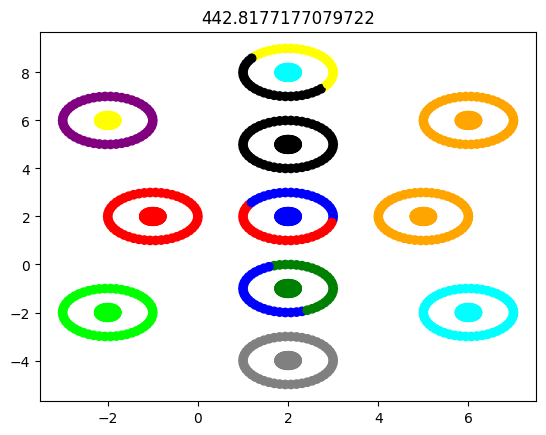

Ground Truth Error is: 421.793764703285


In [12]:
if(kernelKMeansPP_is_enabled):
    kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=10, init='k-means++', verbose=2)
    kernelKMeans.fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernelKMeans.labels_)
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=kernelKMeans.labels_, cmap=ListedColormap(colors))
    plt.title(kernelKMeans.inertia_)
    plt.show()

    # That's the function of grount truth error
    ground_truth_error = kernelKMeans.calculate_ground_truth_error(y)
    print(f"Ground Truth Error is: {ground_truth_error}")

### Global Kernel kMeans

In [8]:
if(globalKernelKMeans_is_enabled):
    globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, verbose=1)
    globalKernelKMeans.fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeans.labels_[K])
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=globalKernelKMeans.labels_[K], cmap=ListedColormap(colors))
    plt.title(globalKernelKMeans.inertia_[K])
    plt.show()

### Global Kernel kMeans++

Solving 2-means
Solving 3-means
Solving 4-means
Solving 5-means
Solving 6-means
Solving 7-means
Solving 8-means
Solving 9-means
Solving 10-means
Solving 11-means
Solving 12-means
Solving 13-means
Solving 14-means
Solving 15-means
Solving 16-means
Solving 17-means
Solving 18-means
Solving 19-means
Solving 20-means
Solving 21-means
Solving 22-means
ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00


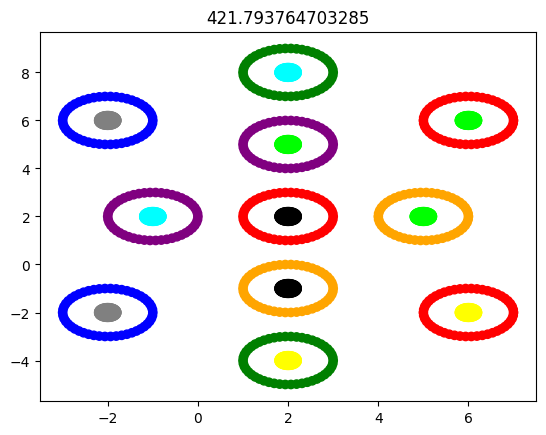

In [10]:
if(globalKernelKMeansPP_is_enabled):
    globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=100, sampling='batch', verbose=1)
    globalKernelKMeansPP.fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
    evaluator.print_evaluation()
    plt.scatter(X[:, 0], X[:, 1], c=globalKernelKMeansPP.labels_[K], cmap=ListedColormap(colors))
    plt.title(globalKernelKMeansPP.inertia_[K])
    plt.show()